# Важно

Данный блокнот нужен лишь для визуализации процесса обучения модели, при попытке запуска данного блокнота вне Google Colaboratory некоторые важные функции не будут работать

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!unzip /content/drive/MyDrive/models/landcover.ai.v1.zip -d dataset

Archive:  /content/drive/MyDrive/models/landcover.ai.v1.zip
replace dataset/images/M-33-48-A-c-4-4.tif? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
import os
import random
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import pandas as pd
import albumentations as A
import glob
import cv2

from datetime import datetime as dt
from IPython.display import clear_output, display


IM_SIZE = 256
AUTOTUNE = tf.data.AUTOTUNE

In [ ]:
#@markdown ###Параметры датасета
#@markdown Название датасета
DATASET_FILE_NAME = "auto" #@param {type:"string"}
#@markdown Количество файлов датасета (позволяет лучше распараллеливать загрузку при обучении)
NUM_FILES = 10 #@param {type:"integer"}
#@markdown Сколько использовать для валидации
NUM_VAL_FILES = 1 # @param {type:"integer"}
#@markdown ###Аугментации
USE_AUGS_IN_VALIDATION_PART = False #@param {type:"boolean"}
#@markdown Вероятность того что изображение не будет аугментированно
NO_AUG_PROB = 0.334 #@param {type:"number"}
#@markdown Вероятность того что изображение будет аугментированно и обе версии изображения будут сохраненны
AUG_AND_SAVE_PROB = 0.0 #@param {type:"number"}
#@markdown Вероятность того что изображение будет аугментированно и будет сохранена только аугментированная версия
ONLY_AUG_PROB = 0.666 #@param {type:"number"}
#@markdown Распределение типов аугментаций
COLOR_AUGS_PROB = 0.3 #@param {type:"number"}
GEOMETRIC_AUGS_PROB = 0.3 #@param {type:"number"}
GEOMETRIC_AND_COLOR_AUGS_PROB = 0.4 #@param {type:"number"}

if DATASET_FILE_NAME == "auto":
    DATASET_FILE_NAME = "lesa dataset " + dt.now().strftime("%d-%m-%y %H-%M")

DATASET_DIR = os.path.join("/content/drive/MyDrive/datasets", DATASET_FILE_NAME)


files = [f"file {i+1}.tfrecords" for i in range(NUM_FILES)]
train_files = [files[i] for i in range(NUM_FILES - NUM_VAL_FILES)]
val_files = [files[-(i+1)] for i in range(NUM_VAL_FILES)]

writer_kwargs = {
    "train_files": train_files,
    "val_files": val_files,
    "use_val_augs": USE_AUGS_IN_VALIDATION_PART
}

In [ ]:
!mkdir "$DATASET_DIR"

mkdir: cannot create directory ‘/content/drive/MyDrive/datasets/lesa dataset 05-10-23 16-20’: File exists


In [ ]:
meta_data = pd.DataFrame({
    "train_files": pd.Series(train_files),
    "val_files": pd.Series(val_files),
    "time_create": pd.Series([dt.now().strftime("%d-%m-%Y %H:%M")])
})
meta_data.to_csv(os.path.join(DATASET_DIR, "metadata.csv"), index=False)

meta_data

,train_files,val_files,time_create
0,file 1.tfrecords,file 10.tfrecords,05-10-2023 16:20
1,file 2.tfrecords,NaN,NaN
2,file 3.tfrecords,NaN,NaN
3,file 4.tfrecords,NaN,NaN
4,file 5.tfrecords,NaN,NaN
5,file 6.tfrecords,NaN,NaN
6,file 7.tfrecords,NaN,NaN
7,file 8.tfrecords,NaN,NaN
8,file 9.tfrecords,NaN,NaN


## Подготовка данных

In [ ]:
#@markdown #Параметры выборки данных
#@markdown Так как в данных содержатся метки для нескольких классов, то необходимо выбрать лишь наиболее подходящие изображения для задачи семантической сегментации лесопарковых зон в городской местности. Из-за этого будут выбраны изображения содержащие классы Woodland и Buildings, но так как изображений подходящих под эти критерии достаточно мало, нужно также выбрать и изображения где просто большое содержание класса Woodland, в конце концов Ростов-на-Дону это не только здания, есть ещё и пригороды.

#@markdown Использовать изображение если плотности классов Woodland and Town (в % от всей площади изображения) больше чем:
LESA_MIN_DENS_1 = 10 # @param {type:"integer"}
TOWN_MIN_DENS_1 = 5 # @param {type:"integer"}
#@markdown иначе, если плотность класса Woodland в следующих пределах (слишком большое содержание класса Woodland не даст модели увидить другие поверхности с которыми придется сталкиваться на практике):
LESA_MIN_DENS_2 = 15 # @param {type:"integer"}
LESA_MAX_DENS_2 = 60 # @param {type:"integer"}

In [ ]:
IMGS_DIR = "/content/dataset/images"
MASKS_DIR = "/content/dataset/masks"
NEW_IMGS_DIR = "/content/new_images"
NEW_MASKS_DIR = "/content/new_masks"

LESA_MIN_AREA_1 = IM_SIZE * IM_SIZE * (LESA_MIN_DENS_1 / 100)
TOWN_MIN_AREA_1 = IM_SIZE * IM_SIZE * (TOWN_MIN_DENS_1 / 100)
LESA_MIN_AREA_2 = IM_SIZE * IM_SIZE * (LESA_MIN_DENS_2 / 100)
LESA_MAX_AREA_2 = IM_SIZE * IM_SIZE * (LESA_MAX_DENS_2 / 100)

img_paths = glob.glob(os.path.join(IMGS_DIR, "*.tif"))
mask_paths = glob.glob(os.path.join(MASKS_DIR, "*.tif"))

img_paths.sort()
mask_paths.sort()


all_images_index = 0
selected_images_index = 0


#os.makedirs(NEW_IMGS_DIR)
#os.makedirs(NEW_MASKS_DIR)
for i, (img_path, mask_path) in enumerate(zip(img_paths, mask_paths)):
    img_filename = os.path.splitext(os.path.basename(img_path))[0]
    mask_filename = os.path.splitext(os.path.basename(mask_path))[0]
    img = cv2.imread(img_path)
    mask = cv2.imread(mask_path)

    assert img_filename == mask_filename and img.shape[:2] == mask.shape[:2]

    k = 0
    for y in np.arange(0, img.shape[0], IM_SIZE):
        for x in np.arange(0, img.shape[1], IM_SIZE):
            img_tile = img[y:y + IM_SIZE, x:x + IM_SIZE]
            mask_tile = mask[y:y + IM_SIZE, x:x + IM_SIZE]

            if img_tile.shape[0] == IM_SIZE and img_tile.shape[1] == IM_SIZE:
                all_images_index += 1

                mask_tile = mask_tile[:, :, 0]

                lesa_area = np.sum(mask_tile[mask_tile == 2])/2
                town_area = np.sum(mask_tile[mask_tile == 1])

                if (lesa_area >= LESA_MIN_AREA_1 and town_area >= TOWN_MIN_AREA_1) or (LESA_MIN_AREA_2 <= lesa_area < LESA_MAX_AREA_2):
                    selected_images_index += 1

                    mask_tile[mask_tile != 2] = 0
                    mask_tile[mask_tile == 2] = 1

                    out_img_path = os.path.join(NEW_IMGS_DIR, "{}_{}.jpg".format(img_filename, k))
                    cv2.imwrite(out_img_path, img_tile)

                    out_mask_path = os.path.join(NEW_MASKS_DIR, "{}_{}.jpg".format(mask_filename, k))
                    cv2.imwrite(out_mask_path, mask_tile)

            k += 1

    clear_output(wait=True)
    print(f"Выполняется {img_filename}: {i + 1}/{len(img_paths)}")
    print(f"Отобранно {selected_images_index} изображений из {all_images_index}")

Выполняется N-34-97-D-c-2-4: 41/41
Отобранно 7402 изображений из 44122


## Аугментации

In [ ]:
geometric_augs = [
    A.RandomSizedCrop(min_max_height=(IM_SIZE*0.75, IM_SIZE), height=IM_SIZE, width=IM_SIZE),
    A.SafeRotate(),
    A.Flip(),
    A.Transpose()
]

color_augs = [
    A.RGBShift(r_shift_limit=(1, -3), g_shift_limit=(7, 5), b_shift_limit=(3, -1)),
    A.ColorJitter(brightness=.25, contrast=.25, saturation=.25, hue=.0),
    A.OpticalDistortion()
]

all_augs = [*geometric_augs, *color_augs]


augs = A.Compose([
    A.Compose(geometric_augs, p=GEOMETRIC_AUGS_PROB),
    A.Compose(color_augs, p=COLOR_AUGS_PROB),
    A.Compose(all_augs, p=GEOMETRIC_AND_COLOR_AUGS_PROB)
]);

# Класс для создания датасета

In [ ]:
def get_feature(image_raw, mask_raw):
    return tf.train.Example(
        features=tf.train.Features(
            feature={
                'image': tf.train.Feature(bytes_list=tf.train.BytesList(value=[tf.io.encode_jpeg(image_raw, format="rgb").numpy()])),
                'mask': tf.train.Feature(bytes_list=tf.train.BytesList(value=[tf.io.encode_jpeg(mask_raw, format="grayscale").numpy()]))
            }
        )
    )


def load_file(file_path):
        return tf.image.decode_jpeg(tf.io.read_file(file_path)).numpy()


class Writer:
    _writer = None

    _count = 0
    _max_count = 0

    def __init__(
        self,
        train_files,
        val_files,
        augmentations: A.Compose,
        probs: list,
        use_val_augs: bool = False
    ):
        self.augmentations = augmentations
        self.probs = probs

        self.train_files = train_files
        self.val_files = val_files
        self.use_val_augs = use_val_augs

    def _write(self, record, aug=False):
        im = load_file(record[0])
        ms = load_file(record[1])[:, :, 0]

        if aug:
            augmented = self.augmentations(image=im, mask=ms)

            self._writer.write(
                get_feature(
                    augmented["image"],
                    augmented["mask"].reshape((IM_SIZE, IM_SIZE, 1))*255
                ).SerializeToString()
            )
        else:
            self._writer.write(
                get_feature(
                    im,
                    ms.reshape((IM_SIZE, IM_SIZE, 1))*255
                ).SerializeToString()
            )

    def _init_new_writer(self, file_name):
        if self._writer:
            self._writer.close()

        self._writer = tf.io.TFRecordWriter(os.path.join(DATASET_DIR, file_name))

    def write(self, images_paths, masks_paths):
        avg_file_len = len(images_paths) / (len(self.train_files) + len(self.val_files))

        train_records = [
            (
                images_paths[int(avg_file_len*i):int(avg_file_len*(i+1))],
                masks_paths[int(avg_file_len*i):int(avg_file_len*(i+1))]
            ) for i in range(len(self.train_files))
        ]

        val_records = []
        for i in range(len(self.train_files), len(self.train_files) + len(self.val_files)):
            if i < (len(self.train_files) + len(self.val_files) - 1):
                val_records.append((
                    images_paths[int(avg_file_len * i):int(avg_file_len * (i + 1))],
                    masks_paths[int(avg_file_len * i):int(avg_file_len * (i + 1))]
                ))
            else:
                val_records.append((
                    images_paths[int(avg_file_len * i):],
                    masks_paths[int(avg_file_len * i):]
                ))

        self._max_count = len(images_paths)

        for file, record in zip(self.train_files, train_records):
            self._init_new_writer(file)

            for rec in zip(*record):
                choice = np.random.choice([0, 1, 2], p=self.probs)

                if choice == 0:                # только оригинал
                    self._write(rec)
                elif choice == 1:              # аугментация и оригинал
                    self._write(rec, aug=True)
                    self._write(rec)
                else:                          # только аугментация
                    self._write(rec, aug=True)

                clear_output(wait=True)
                self._count += 1
                print(f"Train file: \"{file}\"\nИзображение {self._count} из {self._max_count}")


        for file, record in zip(self.val_files, val_records):
            self._init_new_writer(file)

            for rec in zip(*record):
                self._write(rec)

                clear_output(wait=True)
                self._count += 1
                print(f"Val file: \"{file}\"\nИзображение {self._count} из {self._max_count}")

        self._count = 0
        self._writer.close()

# Создание TFRecords файла-датасета

In [ ]:
images_paths = [os.path.join('/content/new_images', path) for path in os.listdir('/content/new_images')]
masks_paths = [os.path.join('/content/new_masks', path) for path in os.listdir('/content/new_masks')]


writer = Writer(
    **writer_kwargs,
    augmentations=augs,
    probs=[NO_AUG_PROB, AUG_AND_SAVE_PROB, ONLY_AUG_PROB]
)

writer.write(images_paths, masks_paths);

Val file: "file 10.tfrecords"
Изображение 7402 из 7402


# Проверка датасета

In [ ]:
feature_description = {
    "image": tf.io.FixedLenFeature([], tf.string),
    "mask": tf.io.FixedLenFeature([], tf.string)
}


def parse_tfrecord_fn(example):
    example = tf.io.parse_single_example(example, feature_description)
    example["image"] = tf.io.decode_jpeg(example["image"], channels=3)
    example["mask"] = tf.io.decode_jpeg(example["mask"], channels=1)
    return example


def show_examples(examples):
    fig, axis = plt.subplots(nrows=round(len(examples["image"])/2), ncols=4)
    fig.set_dpi(256)

    axis = axis.flatten()
    index = 0

    for img, msk in zip(examples["image"], examples["mask"]):
        axis[index].imshow(img)
        axis[index].set_axis_off()

        index += 1

        axis[index].imshow(msk)
        axis[index].set_axis_off()

        index += 1

    plt.show()


def show_images(images, masks):
    fig, axis = plt.subplots(nrows=round(len(images)/2), ncols=4)
    fig.set_dpi(256)

    axis = axis.flatten()
    index = 0

    for img, msk in zip(images, masks):
        axis[index].imshow(img)
        axis[index].set_axis_off()

        index += 1

        axis[index].imshow(msk)
        axis[index].set_axis_off()

        index += 1

    plt.show()

In [ ]:
dataset = (
    tf.data.TFRecordDataset([os.path.join(DATASET_DIR, fl) for fl in files], num_parallel_reads=AUTOTUNE)
    .map(parse_tfrecord_fn, num_parallel_calls=AUTOTUNE)
    .batch(10)
    .cache()
    .prefetch(AUTOTUNE)
);

Аугментированный датасет

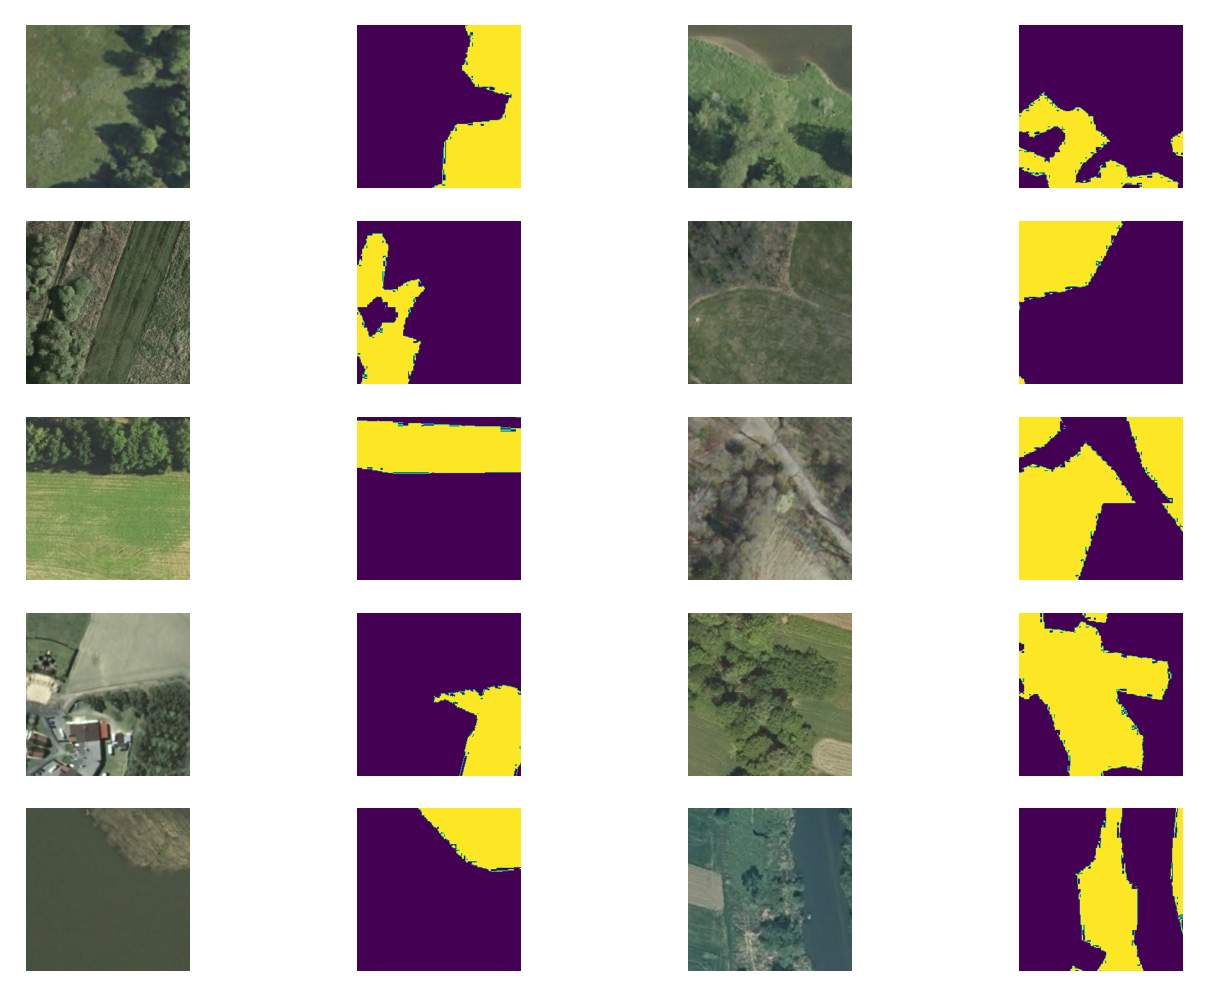

In [ ]:
show_examples(list(dataset.take(10))[0]);

Оригинальный датасет

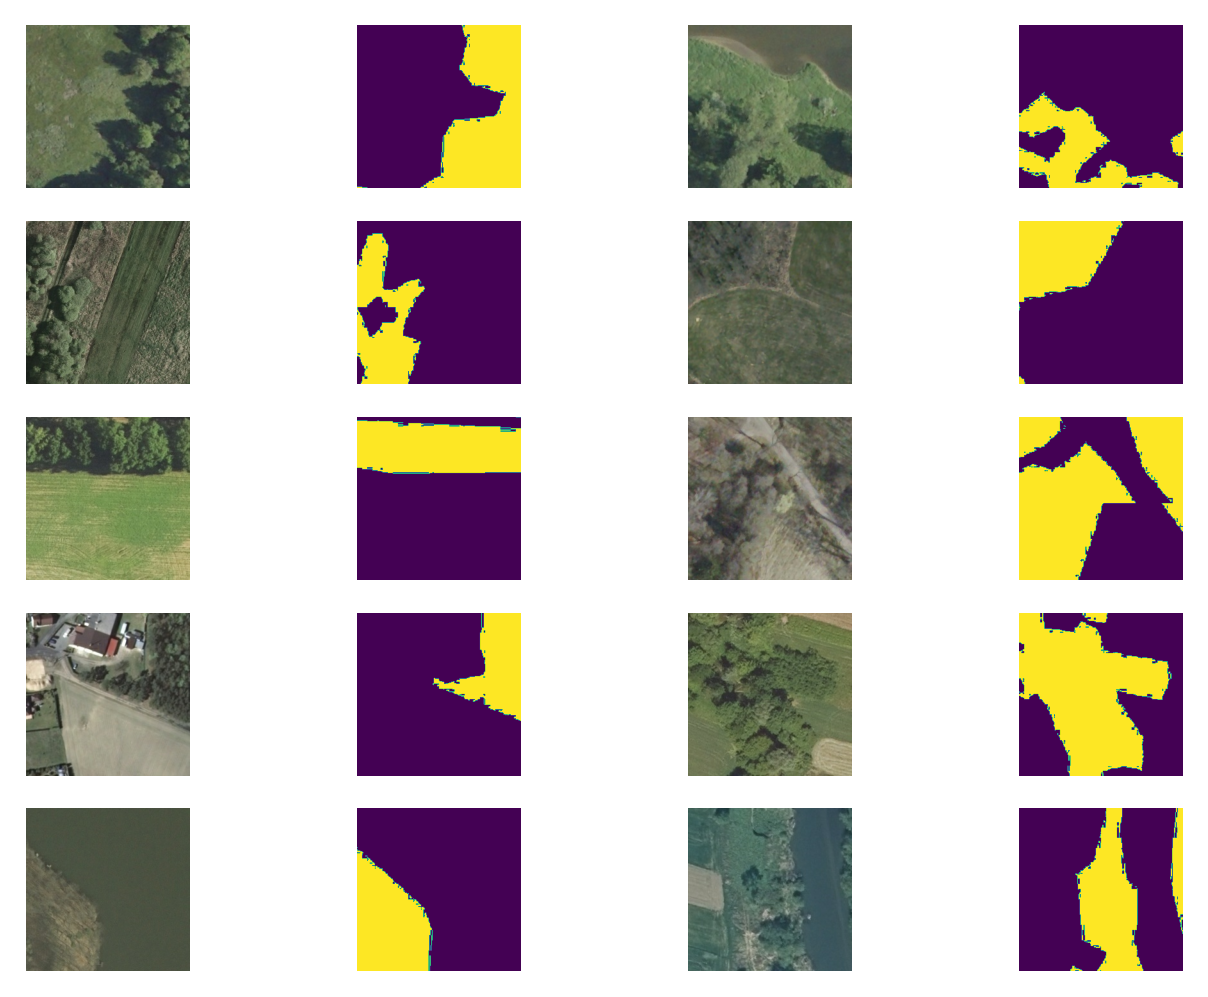

In [ ]:
images = [load_file(os.path.join('/content/new_images', path)) for path in os.listdir('/content/new_images')[:10]]
masks = [load_file(os.path.join('/content/new_masks', path))[:, :, 0] for path in os.listdir('/content/new_masks')[:10]]

show_images(images, masks);